## Project 11: 인공지능으로 세상에 없던 새로운 패션 만들기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('tensorflow', tf.__version__)
print(imageio.__version__)

tensorflow 2.6.0
2.9.0


## Step1. 작업환경 구성하기

*dcgan_newimage안의 cifar10 안에 generated_samples, training_checkpoints, training_history 를 만듭니다.

## Step2. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

* 학습에 사용한 train_x의 이미지를 -1, 1로 정규화
* 로드한 학습 데이터를 시가고하를 통해 확인
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성

In [3]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# 각 픽셀을 [-1, 1]로 정규화시킵니다.
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
# dataset의 shape
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


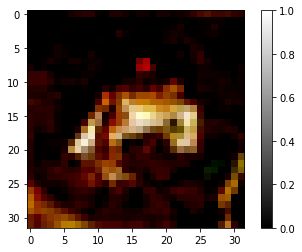

In [7]:
plt.imshow(train_x[0].reshape(32, 32,3), cmap='gray')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

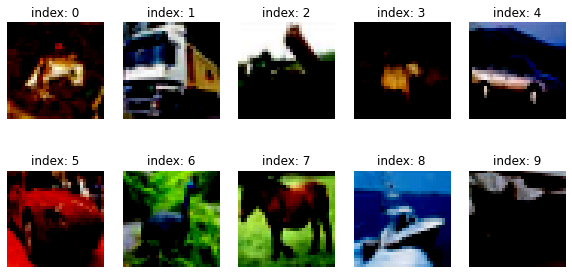

In [8]:
# 10개정도 데이터셋을 살펴봅시다.
plt.figure(figsize=(10,5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32,3), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
    
plt.show()

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Step3. 생성자 모델 구현하기

* (32,32,3)의 shape을 가진 이미지를 생성하는 생성자 모델 구현함수 작성
* noise = tf.random.normal([1,100])으로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지 생성
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [12]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

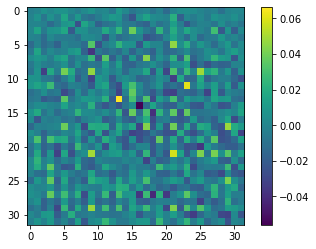

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## Step4. 판별자 모델 구현하기
* (32,32,3)의 이미지를 입력으로 받아 1dim의 판별결과를 출력하는 판별자 모델 구현함수를 작성
* step 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
# 판별자모델을 dicriminator 변수로 생성, 모델 세부내용 확인
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

## Step 5. 손실함수와 최적화 함수 구현하기

* 생성자와 판별자의 손실함수 구현
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도를 계산하는 함수 구현
* 생성자와 판별자를 최적화하는 optimizer 정의

* GAN에서 cross_entropy를 사용, 판별자에서 한개의 이미지가 가짜인지 진짜인지 나타내는 2개의 클래스간의 분류문제를 풀어야 하므로 binary cross entropy를 사용.
* real image 1, fake image 0
* 생성자 : 판별자가 Fake Image에 대해 판별한 값, D(fake_image)값이 1에 가까워지도록 목표
* 판별자 : Real Image 판별값, 즉 D(real_image)는 1에 Fake image의 판별값 D(fake_image)는 0에 가까워지도록 목표

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# fake_output, D(fake_image)
# real_output, D(real_image)

# generator_loss는 fake_output이 1에 가까워지기를 바라므로, tf.ones_like와의 교차 엔트로피를 계산
# cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 1에 가까울 수록 작은 값을 가집니다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# disciriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### 최적화 함수(Optimizer) 정의

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Step 6. 훈련과정 상세기능 구현하기
* 1개의 미니배치의 훈련과정을 처리하는 train_step() 함수 구현
* 16개의 고정된 seed를 입력으로 하여 훈련과정동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리를 그래프로 시각화하는 draw_train_history() 함수 구현
* training_checkpoints 디렉토리에 몇 epoch 마다 모델을 저장하는 checkpoint 모듈 설정

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [26]:
# checkpoint 모델 저장
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Step 7. 학습 과정 진행하기
* 50 epoch 이상
* 학습 과정에서 생성된 샘플 이미지로 만든 GIF파일을 통해 학습 진행과정을 시각적으로 표현
* 학습과정을 담은 샘플 이미지, GIF 파일, 학습 진행 그래프

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

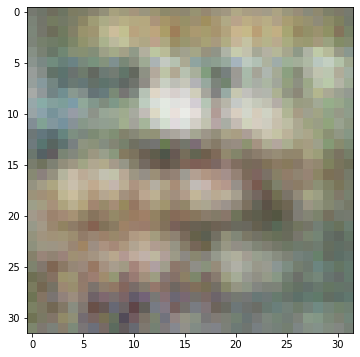

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## Step 7. 학습과정 진행하기
* 최소 50 epoch만큼의 모델 학습을 진행.
* 학습과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현


In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

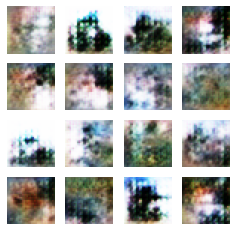

Time for training : 792 sec


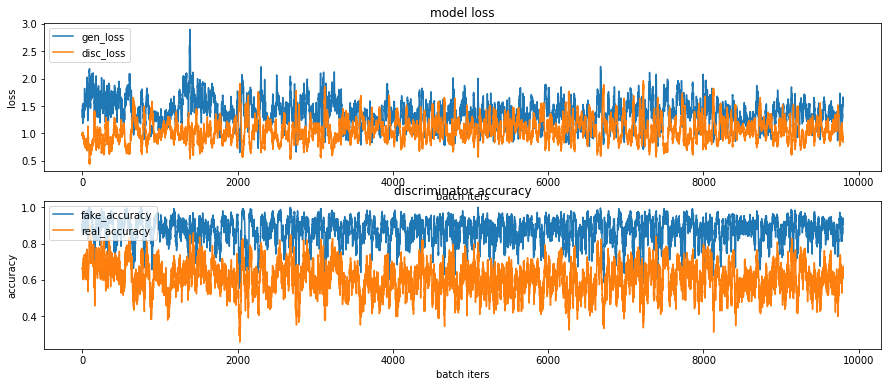

CPU times: user 13min 12s, sys: 1min 23s, total: 14min 36s
Wall time: 13min 13s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
